In [1]:
import pandas as pd
from sklearn import svm
import numpy as np

import matplotlib.pyplot as plt

Wczytywanie danych...

In [2]:
data = pd.read_stata('data.dta')

Do modelu zostały wybrane następujące zmienne:

1) **ppincimp** - dochód domostwa

2) **partyid7** - przynależność do partii politycznej

3) **ppwork** - status zatrudnienia

4) **Q6A** - czy partner jest Latynosem lub Hiszpanem

W modelu zmienną objaśnianą jest binarna zmiena <u>**S1**</u> oznaczający bycie w związku małżeńskim.

In [3]:
prepared_columns = ['S1','ppincimp', 'partyid7', 'ppwork', 'Q6A']
data_in = data[prepared_columns]

## Tworzenie słownika 
W związku z dużą liczbą kategorii w niektorych zmiennych utworzony został słownik z kategorami i odpowiadającymi im nazwami.

In [4]:
categories_dict = {}
for col in data_in.columns:
    categories_dict[col] = dict(enumerate(data_in.loc[:, col].cat.categories))

categories_dict

{'S1': {0: 'Yes, I am Married', 1: 'No, I am not Married'},
 'ppincimp': {0: 'Less than $5,000',
  1: '$5,000 to $7,499',
  2: '$7,500 to $9,999',
  3: '$10,000 to $12,499',
  4: '$12,500 to $14,999',
  5: '$15,000 to $19,999',
  6: '$20,000 to $24,999',
  7: '$25,000 to $29,999',
  8: '$30,000 to $34,999',
  9: '$35,000 to $39,999',
  10: '$40,000 to $49,999',
  11: '$50,000 to $59,999',
  12: '$60,000 to $74,999',
  13: '$75,000 to $84,999',
  14: '$85,000 to $99,999',
  15: '$100,000 to $124,999',
  16: '$125,000 to $149,999',
  17: '$150,000 to $174,999',
  18: '$175,000 to $199,999',
  19: '$200,000 to $249,999',
  20: '$250,000 or more'},
 'partyid7': {0: 'Strong Republican',
  1: 'Not Strong Republican',
  2: 'Leans Republican',
  3: 'Undecided/Independent/Other',
  4: 'Leans Democrat',
  5: 'Not Strong Democrat',
  6: 'Strong Democrat'},
 'ppwork': {0: 'Working - as a paid employee',
  1: 'Working - self-employed',
  2: 'Not working - on temporary layoff from a job',
  3: 'Not 

In [5]:
data_in = data_in.dropna()
data_in.shape

(2856, 5)

## Transformacja zmiennych

In [6]:
y = data_in['S1'].cat.codes
X = data_in.iloc[:, 1:].apply(lambda x: x.cat.codes, axis=0)

## Utworzenie modelu

In [7]:
X.values

array([[17,  1,  6,  1],
       [19,  4,  0,  1],
       [18,  6,  0,  1],
       ...,
       [16,  5,  0,  1],
       [12,  4,  0,  1],
       [10,  4,  0,  1]], dtype=int8)

In [8]:
svm_model = svm.SVC(gamma=0.01, probability=True)
svm_model.fit(X.values, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Zostały utworzone trzy funkcje w tym jedna główna (<u>ceteris_paribus_plot</u>). 

Funkcja ceteris_paribus_plot przyjmuje następujące argumenty:
1. model - model, który zostanie wyjaśniony
1. row - którą obserwację będziemy uznawać za "bazową"
1. test_x - dane do modelu
1. random - zmienna określająca czy wybór obserwacji "bazowej" ma nastąpić w sposób losowy
1. col - kolumna do wyjaśnienia
1. categories_dict - słownik z kategoriami w zmiennych

In [19]:
def ceteris_paribus_plot(model, row: int, test_x: pd.DataFrame, random: bool, col: str, categories_dict: dict):
    if random:
        selected_observation = test_x.iloc[np.random.randint(1, len(test_x)), :]
    else:
        selected_observation = test_x.iloc[row, :]
        
    possible_values = sorted(test_x[col].unique())
    probabilities = create_probabilities(model, selected_observation, col, possible_values)
    
    create_plot(possible_values, probabilities, col)
    print(categories_dict[col])
    
    
def create_probabilities(model, test_x, col, possible_values):
    probas = []
    for i in possible_values:
        test_x[col] = i
        probas.append(model.predict_proba([test_x.values])[0][0])
    
    return probas


def create_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'Ceteris Paribus plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()
    
    
def pd_plot(model, test_x, col):
    values_range = list(np.sort(test_x[col].unique()))
    prob_dict = {}
    for value in values_range:
        temp = test_x.copy()
        temp[col] = value
        pred = temp.apply(lambda row: model.predict_proba([row.values])[0][0], axis=1)
        prob_dict[value] = np.mean(pred)
        
    create_pd_plot(prob_dict.keys(), prob_dict.values(), col)

def create_pd_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'pd_plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()
    

def m_plot(model, test_x, col):
    tt = test_x.copy()
    values_range = list(np.sort(test_x[col].unique()))
    tt['pred'] = tt.apply(lambda row: model.predict_proba([row.values])[0][0], axis=1)
    prob_dict = {}
    for value in values_range:
        temp = tt[tt[col] == value]
        prob_dict[value] = np.mean(temp.pred)
        
    create_m_plot(prob_dict.keys(), prob_dict.values(), col)

    
def create_m_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'M_plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()

Przeanalizowano wpływ zmiennej związanej z dochodem w gospodarstwie. Jak widać im więcej dochodu w gospodastwie tym większe prawdopodobieństwo, że osoba jest w związku małżeńskim.

Wariancja zmienne sugeruje, że zmienna ta jest istotna w modelu.

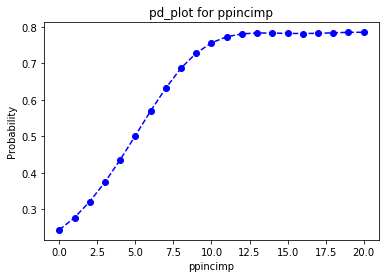

In [20]:
pd_plot(svm_model, X, 'ppincimp')

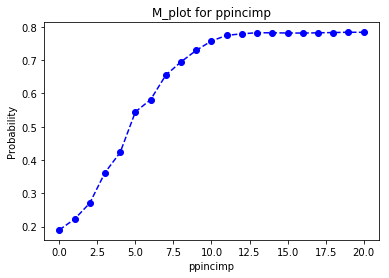

In [21]:
m_plot(svm_model, X, 'ppincimp')

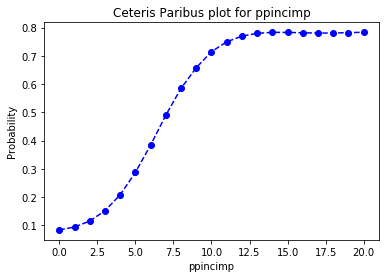

{0: 'Less than $5,000', 1: '$5,000 to $7,499', 2: '$7,500 to $9,999', 3: '$10,000 to $12,499', 4: '$12,500 to $14,999', 5: '$15,000 to $19,999', 6: '$20,000 to $24,999', 7: '$25,000 to $29,999', 8: '$30,000 to $34,999', 9: '$35,000 to $39,999', 10: '$40,000 to $49,999', 11: '$50,000 to $59,999', 12: '$60,000 to $74,999', 13: '$75,000 to $84,999', 14: '$85,000 to $99,999', 15: '$100,000 to $124,999', 16: '$125,000 to $149,999', 17: '$150,000 to $174,999', 18: '$175,000 to $199,999', 19: '$200,000 to $249,999', 20: '$250,000 or more'}


In [22]:
ceteris_paribus_plot(svm_model, 100, X, True, 'ppincimp', categories_dict)

Druga zmienna oznacza preferencje polityczne. Zmienna tak - jak wynika z wykresu - prawdopodobnie nie ogrywa znaczącej roli w modelu.

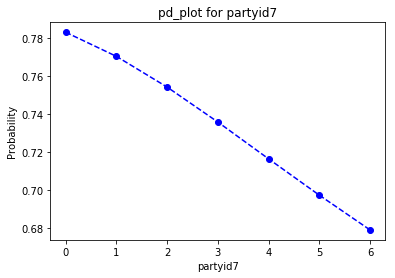

In [23]:
pd_plot(svm_model, X, 'partyid7')

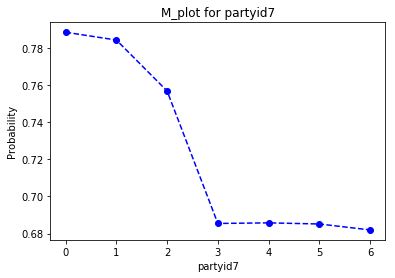

In [24]:
m_plot(svm_model, X, 'partyid7')

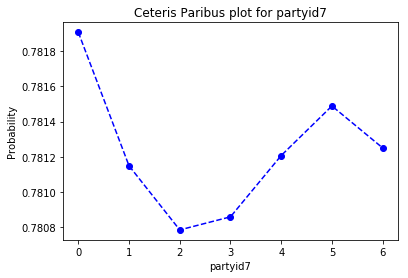

{0: 'Strong Republican', 1: 'Not Strong Republican', 2: 'Leans Republican', 3: 'Undecided/Independent/Other', 4: 'Leans Democrat', 5: 'Not Strong Democrat', 6: 'Strong Democrat'}


In [25]:
ceteris_paribus_plot(svm_model, 100, X, True, "partyid7", categories_dict)

Wykresy oparte na metodzie Ceteris Paribus oraz M_plot nie różnią się w wielki sposób, choć wykazują pewne różnice. Marginal Plot biorący pod uwagę lokalne wartości oczekiwane predykcji, są w pewnych obszarach zgoła inne aniżeli Ceteris Paribus Plots czy PD plots. Również są mniej gładkie. Wynikać to może z obliczenia lokalnych, a nie globalnych prawdopodobieństw i rozbicia naszej populacji na mniejsze podpopulacje podobne do siebie w pewnym względzie (w pewnej zmiennej).